**Probabilistic Numerics package**  --> https://probnum.readthedocs.io/en/latest/index.html
  
  
**Linear Solver:**  
  
- To quantify uncertainty arising from intractable or incomplete numerical computation and from stochastic input  
- Solving the system with one of ProbNum’s linear solvers.  
- Visualizing the return objects of the solver: These are distributions that describe the values of possible solutions and how probable they are.

In [1]:
!pip install probnum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 4.3 MB/s eta 0:00:00


In [2]:
import probnum as pn

/usr/local/lib/python3.10/dist-packages/probnum/randprocs/covfuncs/_covariance_linear_operator.py:16: UserWarning: KeOps is not installed and currently unavailable for Windows.This may prevent scaling to large datasets.
  warnings.warn(


In [4]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm


<ipython-input-4-3c844dd9d340>:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "svg")


Let's examine a linear system represented as:  
Ax=b  
where A is a symmetric positive definite matrix, b is a vector, and
x is the unknown solution of the system.  
  
The resolution of such a linear system stands as one of the foundational computations in statistics, machine learning, and scientific computing. A multitude of problems can be distilled down to solving one or more (often large-scale) linear systems.   
In this context, we'll tackle such a system using one of ProbNum's probabilistic linear solvers.  
  
ProbNum provides a convenient way to generate test problems via its problems zoo package. Specifically, we generate an n-dimensional symmetric positive definite random matrix   
A utilizing the function random_spd_matrix, which allows for the specification of a predetermined eigenspectrum. Additionally, we generate a random normal vector b

In [5]:
import numpy as np
from probnum.problems.zoo.linalg import random_spd_matrix

rng = np.random.default_rng(42)  # for reproducibility
n = 25  # dimensionality

# generate linear system
spectrum = 10 * np.linspace(0.5, 1, n) ** 4
A = random_spd_matrix(rng=rng, dim=n, spectrum=spectrum)
b = rng.normal(size=(n, 1))

print("Matrix condition: {:.2f}".format(np.linalg.cond(A)))
print("Eigenvalues: {}".format(np.linalg.eigvalsh(A)))

Matrix condition: 16.00
Eigenvalues: [ 0.625       0.73585981  0.8608519   1.00112915  1.15788966  1.33237674
  1.52587891  1.73972989  1.97530864  2.23403931  2.51739125  2.82687905
  3.1640625   3.53054659  3.92798153  4.35806274  4.82253086  5.32317173
  5.86181641  6.44034115  7.06066744  7.72476196  8.43463662  9.19234853
 10.        ]


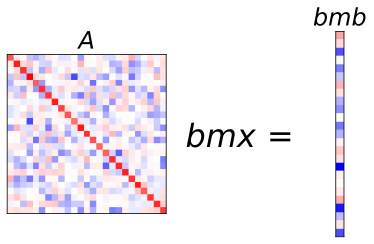

In [7]:
# Plot linear system
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(5, 3.5),
    sharey=True,
    squeeze=False,
    gridspec_kw={"width_ratios": [4, 0.25, 0.25, 0.25]},
)

vmax = np.max(np.hstack([A, b]))
vmin = np.min(np.hstack([A, b]))

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

axes[0, 0].imshow(A, cmap="bwr", norm=norm)
axes[0, 0].set_title("$A$", fontsize=24)
axes[0, 1].text(0.5, A.shape[0] / 2, "$bm{x}$", va="center", ha="center", fontsize=32)
axes[0, 1].axis("off")
axes[0, 2].text(0.5, A.shape[0] / 2, "$=$", va="center", ha="center", fontsize=32)
axes[0, 2].axis("off")
axes[0, 3].imshow(b, cmap="bwr", norm=norm)
axes[0, 3].set_title("$bm{b}$", fontsize=24)
for ax in axes[0, :]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

We now use ProbNum’s probabilistic linear solver problinsolve to estimate the solution vector x


In [12]:
from probnum.linalg import problinsolve

# Solve with probabilistic linear solver
x, Ahat, Ainv, info = problinsolve(A=A, b=b, maxiter=100)
print(info)

{'iter': 20, 'maxiter': 100, 'resid_l2norm': 4.30500678269492e-06, 'trace_sol_cov': 0.8123280378491355, 'conv_crit': 'resid_rtol', 'rel_cond': None}


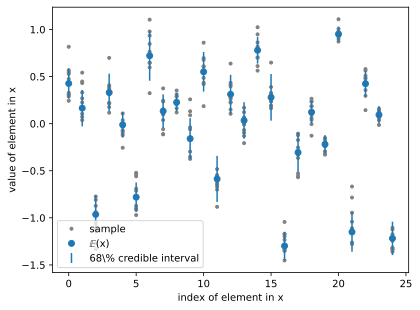

In [13]:
n_samples = 10
x_samples = x.sample(rng=rng, size=n_samples)
x_samples.shape

plt.figure()
plt.plot(x_samples[0, :], '.', color='gray', label='sample')
plt.plot(x_samples[1:, :].T, '.', color='gray')
plt.errorbar(np.arange(0, 25), x.mean, 1 * x.std, ls='none',
             label='68\% credible interval')
plt.plot(x.mean, 'o', color='C0', label='$\mathbb{E}(\mathsf{x})$')
plt.xlabel("index of element in $\mathsf{x}$")
plt.ylabel("value of element in $\mathsf{x}$")
plt.legend()
plt.show()

Check Inverse matrix H

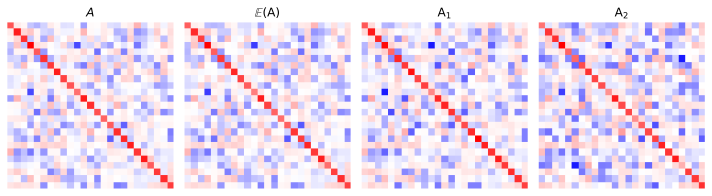

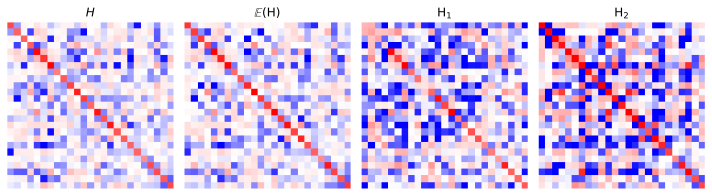

In [14]:
# Draw samples
rng = np.random.default_rng(seed=42)
Ahat_samples = Ahat.sample(rng=rng, size=3)
Ainv_samples = Ainv.sample(rng=rng, size=3)

vmax = np.max(np.hstack([A, b]))
vmin = np.min(np.hstack([A, b]))

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot A
rvdict = {
    "$A$": A,
    "$\mathbb{E}(\mathsf{A})$": Ahat.mean.todense(),
    "$\mathsf{A}_1$": Ahat_samples[0],
    "$\mathsf{A}_2$": Ahat_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

H = np.linalg.inv(A)
vmax = np.max(H)
vmin = np.min(H)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot H
rvdict = {
    "$H$": H,
    "$\mathbb{E}(\mathsf{H})$": Ainv.mean.todense(),
    "$\mathsf{H}_1$": Ainv_samples[0],
    "$\mathsf{H}_2$": Ainv_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

mean estimates look fairly close to the true values A and H, even though the solver only ran for maxiter 100 steps.
  
The uncertainty of the solver about these quantities is still relatively high by looking at the samples from A and H


**ODE Solver:**
  
First we define the ODE problem. We use Lotka-Volterra. Once the ODE functions are defined, they are gathered in a data structure describing the initial value problem.

In [16]:
from probnum import diffeq, filtsmooth, randvars, randprocs, problems
import numpy as np

import matplotlib.pyplot as plt

In [17]:
def f(t, y):
    y1, y2 = y
    return np.array([0.5 * y1 - 0.05 * y1 * y2, -0.5 * y2 + 0.05 * y1 * y2])


def df(t, y):
    y1, y2 = y
    return np.array([[0.5 - 0.05 * y2, -0.05 * y1], [0.05 * y2, -0.5 + 0.05 * y1]])


t0 = 0.0
tmax = 20.0
y0 = np.array([20, 20])

lotka_volterra = problems.InitialValueProblem(t0=t0, tmax=tmax, y0=y0, f=f, df=df)

Next, we define a prior distribution and a step-size-selection rule. The former is almost always an integrated Wiener process. The latter can be an adaptive or constant rule.  
Then we construct the ODE filter and solve the ODE and plot the solution.

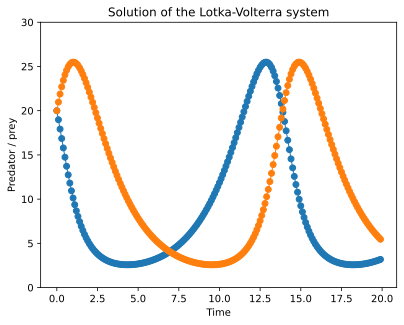

In [18]:
iwp = randprocs.markov.integrator.IntegratedWienerProcess(
    initarg=lotka_volterra.t0,
    num_derivatives=4,
    wiener_process_dimension=lotka_volterra.dimension,
    forward_implementation="sqrt",
    backward_implementation="sqrt",
)

firststep = diffeq.stepsize.propose_firststep(lotka_volterra)
adaptive_steps = diffeq.stepsize.AdaptiveSteps(
    firststep=firststep, atol=1e-2, rtol=1e-3
)

solver = diffeq.odefilter.ODEFilter(
    steprule=adaptive_steps,
    prior_process=iwp,
)
odesol = solver.solve(ivp=lotka_volterra)

evalgrid = np.arange(lotka_volterra.t0, lotka_volterra.tmax, step=0.1)
sol = odesol(evalgrid)

plt.plot(evalgrid, sol.mean, "o-", linewidth=1)
plt.ylim((0, 30))
plt.xlabel("Time")
plt.ylabel("Predator / prey")
plt.title("Solution of the Lotka-Volterra system")
plt.show()

**Linear Gaussian filtering and smoothing:**